# Imports

**NOTE** This runs on `thesis_env` environment

In [1]:
import pandas as pd
import numpy as np
import pickle
import datetime

In [2]:
# gfx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# maps
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

# Import Data

Data is being pulled automatically from RKStudio server and then saved to `3_3_2_processed_data` folder.


**PROCESS**
1. `launchd` runs the `.plist` file `/Library/LaunchAgents/thesis.djw.pull-rkstudio-data.plist` every day at 10:40am
2. `thesis.djw.pull-rkstudio-data.plist` runs `.sh` script `/download/download_rkstudio_data.sh`
3. `download_rkstudio_data.sh` runs `.py` script `/download/download_rkstudio_data.py`
4. `download_rkstudio_data.py` downloads any **new** files from RK Studio, and saves to `.pkl` in `3_3_2_processed_data` folder.

---

**Note:** 
- The `create_dict_df()` function in `download_rkstudio_data.py` is inefficient as it recreates the file from scratch each time it runs instead of just appending new data. If things get slow this could be a spot to address.
- The `create_dict_df()` function is also simply replacing previous file with current file

In [3]:
save_path = "/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/"

in_file = open(save_path + "app_data.pkl", "rb")
app_data = pickle.load(in_file)

## Note

Feature columns should be correct as of **March 9, 2021**

---

**DateTime** is in [ISO 8601 format](https://en.wikipedia.org/wiki/ISO_8601)
- e.g. `2021-03-05T13:53:52+00:00`
- the +/- offset refers to `UTC`
- but the time is CORRECT for local time
- looks like it was originally created using:

```
# UTC to ISO 8601 with Local TimeZone information without microsecond (Python 3):

import datetime
datetime.datetime.now().astimezone().replace(microsecond=0).isoformat()
>>> 2020-03-20T14:31:43+13:00
```
---

**File Names** are:

In [4]:
list(app_data.keys())

['AppleLocationVisits',
 'HealthKitActivitySummaries',
 'HealthKitCharacteristics',
 'HealthKitSamples',
 'StudyParticipants',
 'SurveyResults',
 'SurveyStepResults',
 'SurveyQuestionResults',
 'SurveyConsentSignatureResults',
 'SurveyStroopResults',
 'SurveyPSATResults',
 'SurveyTrailmakingResults',
 'SurveyTowerOfHanoiResults',
 'SurveyReactionTimeResults',
 'SurveySpatialSpanMemoryResults',
 'SurveyTasks',
 'Manifest',
 'Notifications',
 'AuxiliaryData']

# Passive Data

We have three exports from [RKStudio](https://rkstudio.careevolution.com) of interest:
- `HealthKitActivitySummaries`
- `HealthKitSamples`
- `AppleLocationVisits`

There is quite a bit of overlap between the`HealthKitActivitySummaries` and `HealthKitSamples` but we will use some of them that are not clearly available in the `HealthKitSamples`.


In [5]:
list(app_data['HealthKitActivitySummaries'].columns)
    

['HealthKitActivitySummaryKey',
 'ParticipantIdentifier',
 'StartDate',
 'EndDate',
 'ActiveEnergyBurned',
 'ActiveEnergyBurnedGoal',
 'AppleExerciseTime',
 'AppleExerciseTimeGoal',
 'AppleStandHours',
 'AppleStandHoursGoal',
 'InsertedDate']

In [10]:
app_data['HealthKitSamples'].Type.value_counts()


ActiveEnergyBurned            419064
RestingEnergyBurned           186525
HeartRate                     155940
DistanceWalkingRunning        101715
Steps                          81706
AppleStandTime                 17844
HeadphoneAudioExposure         17012
WalkingSpeed                   14063
DistanceCycling                13316
StandHourInterval               8056
EnvironmentalAudioExposure      6443
SleepAnalysisInterval           2585
HeartRateVariability            1778
DailySteps                       968
RestingHeartRate                 410
WalkingHeartRateAverage          348
MindfulSession                     1
Name: Type, dtype: int64

In [7]:
app_data['AppleLocationVisits'].head(3)


,AppleLocationVisitKey,ParticipantIdentifier,ArrivalTime,DepartureTime,Latitude,Longitude,HorizontalAccuracy,InsertedDate
0,b7b1cdd6-562f-ec11-aab2-0afb9334277d,229876e0-c6b0-42b7-9d83-85f07f12eb05,2021-10-17T10:25:41-04:00,NaN,43.774647,-79.334290,10.0,2021-10-17T14:31:03Z
1,80e3f748-582f-ec11-aab2-0afb9334277d,229876e0-c6b0-42b7-9d83-85f07f12eb05,2021-10-17T10:36:04-04:00,NaN,43.777682,-79.338797,10.0,2021-10-17T14:41:25Z
2,4012d466-582f-ec11-aab2-0afb9334277d,229876e0-c6b0-42b7-9d83-85f07f12eb05,2021-10-17T10:36:04-04:00,2021-10-17T10:36:48-04:00,43.777682,-79.338797,10.0,2021-10-17T14:42:10Z


### Add Date

**NOTE** 
- for the `StudyDay` we will count up until 4am the *next day* to account for night owls...
    - assumption is that no one gets up before 4am
- end date seems to be `Date`
    - also seems to already be converted to local time (-4/-5)


**WARNING**

Right now we are assuming everyone is in the same timezone...(Eastern)
- What about when people travel??

In [8]:
# Add date column
app_data['HealthKitSamples']['StudyDay'] = 0

# Faster way than loop to do this?
for i in range(len(app_data['HealthKitSamples'].Date)):

    if pd.to_datetime(app_data['HealthKitSamples'].Date[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 5:
        # subtract one day from date
        app_data['HealthKitSamples'].loc[i, 'StudyDay'] = pd.to_datetime(app_data['HealthKitSamples'].Date[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        app_data['HealthKitSamples'].loc[i, 'StudyDay'] = pd.to_datetime(app_data['HealthKitSamples'].Date[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

## Sleep

We are collecting sleep in the `Self_Report` data already, but we are interested to see how this correlates with sleep estimated from smartphones and Apple Watches.



In [140]:
type_vals = ['SleepAnalysisInterval']

df = app_data['HealthKitSamples'].loc[app_data['HealthKitSamples'].Type.isin(type_vals)].reset_index(drop=True)
df.head(3)


,HealthKitSampleKey,ParticipantIdentifier,StartDate,Date,Type,Value,Units,SourceIdentifier,SourceName,SourceVersion,...,DeviceModel,DeviceManufacturer,DeviceHardwareVersion,DeviceSoftwareVersion,DeviceFirmwareVersion,DeviceFDAIdentifier,DeviceLocalIdentifier,Metadata,InsertedDate,StudyDay
0,80995583-5e2f-ec11-aab2-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,2021-10-17T02:52:23-04:00,2021-10-17T08:40:51-04:00,SleepAnalysisInterval,InBed,NaN,com.apple.health.325BFB0A-B3E5-430C-9A1A-A97ED...,Michael’s iphone,14.7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""HKTimeZone"":""America\/Toronto""}",2021-10-17T15:26:00Z,2021-10-17
1,86995583-5e2f-ec11-aab2-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,2021-10-17T08:41:01-04:00,2021-10-17T08:41:02-04:00,SleepAnalysisInterval,InBed,NaN,com.apple.health.325BFB0A-B3E5-430C-9A1A-A97ED...,Michael’s iphone,14.7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""HKTimeZone"":""America\/Toronto""}",2021-10-17T15:26:00Z,2021-10-17
2,89995583-5e2f-ec11-aab2-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,2021-10-17T08:41:05-04:00,2021-10-17T09:24:35-04:00,SleepAnalysisInterval,InBed,NaN,com.apple.health.325BFB0A-B3E5-430C-9A1A-A97ED...,Michael’s iphone,14.7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""HKTimeZone"":""America\/Toronto""}",2021-10-17T15:26:00Z,2021-10-17


In [141]:
df.Value.value_counts()

Asleep    1530
InBed     1055
Name: Value, dtype: int64

---
Sleep is a bit tricky as:
1. Sleeping often bridges two days
2. There are people that sleep in late and/or nap

To try and deal with this we label all sleep that happens before 6pm as belonging to the **previous day**

In [142]:
# Add date column
df['SleepDay'] = 0

# Faster way than loop to do this?
for i in range(len(df.Date)):

    if pd.to_datetime(df.Date[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 18:
        # subtract one day from date
        df.loc[i, 'SleepDay'] = pd.to_datetime(df.Date[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        df.loc[i, 'SleepDay'] = pd.to_datetime(df.Date[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

---
Now we want to calculate the duration of each `InBed` and `Asleep` `Value`...


In [143]:
df['Duration'] = [(datetime.datetime.fromisoformat(finish) - datetime.datetime.fromisoformat(start)).seconds/60 for start,finish in zip(df['StartDate'],df['Date'])]

In [145]:
# Get sum for each value (InBed, Asleep) for each participant for each SLEEP day
df = pd.DataFrame(df.groupby(['SleepDay','ParticipantIdentifier', 'Value'])['Duration'].sum()).reset_index()

# convert from long to wide
df = df.pivot_table(index=['SleepDay', 'ParticipantIdentifier'],
                    columns='Value', 
                    values='Duration').reset_index()

---
`SleepDay` was essentially a proxy for `StudyDay` but with additional hours (until 18h00) to account for long sleepers and naps.

So we will change it back to `SleepDay` to join later.

In [146]:
# Get rid of index name (set to "Value")
df.columns.name = None

# Rename columns
df.rename(columns={'SleepDay': 'StudyDay',
                   'Asleep': 'Passive_Asleep',
                   'InBed' : 'Passive_InBed'
                  }, inplace=True)

df.head(3)

,StudyDay,ParticipantIdentifier,Passive_Asleep,Passive_InBed
0,2020-12-11,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,550.083333
1,2020-12-12,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,399.983333
2,2020-12-13,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,423.650000


### Plot

In [147]:
# get dates ordered so plot isn't weird
df.sort_values(by=['StudyDay'], inplace=True)

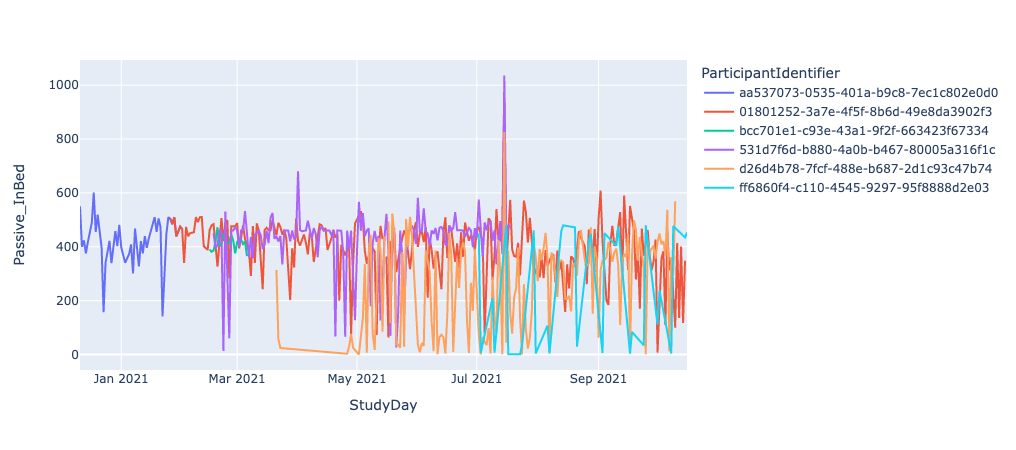

In [148]:
fig = px.line(df, x="StudyDay", y="Passive_InBed", color='ParticipantIdentifier')
fig.show()

### Join

In [149]:
# create master df_tasks, as df will be reassigned
df_passive = df

## Heart

We will take:

- `RestingHeartRate`
- `WalkingHeartRateAverage`
- `HeartRateVariability`

Should we consider max heart rate?

In [150]:
type_vals = ['RestingHeartRate', 'WalkingHeartRateAverage', 'HeartRateVariability']

df = app_data['HealthKitSamples'].loc[app_data['HealthKitSamples'].Type.isin(type_vals)].reset_index(drop=True)
df.head(3)

,HealthKitSampleKey,ParticipantIdentifier,StartDate,Date,Type,Value,Units,SourceIdentifier,SourceName,SourceVersion,...,DeviceModel,DeviceManufacturer,DeviceHardwareVersion,DeviceSoftwareVersion,DeviceFirmwareVersion,DeviceFDAIdentifier,DeviceLocalIdentifier,Metadata,InsertedDate,StudyDay
0,82abd255-472e-ec11-aab2-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-15T22:42:50-07:00,2021-10-15T22:43:51-07:00,HeartRateVariability,41.825531005859375,ms,com.apple.health.3DE6B5C0-C75C-4B79-AE12-A1779...,Daniel’s Apple Watch,7.3.3,...,Watch,Apple Inc.,"Watch6,1",7.3.3,NaN,NaN,NaN,{},2021-10-16T06:07:31Z,2021-10-15
1,c8656295-982e-ec11-aab2-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-16T01:27:31-07:00,2021-10-16T01:28:36-07:00,HeartRateVariability,56.965450286865234,ms,com.apple.health.3DE6B5C0-C75C-4B79-AE12-A1779...,Daniel’s Apple Watch,7.3.3,...,Watch,Apple Inc.,"Watch6,1",7.3.3,NaN,NaN,NaN,{},2021-10-16T15:49:06Z,2021-10-16
2,cf656295-982e-ec11-aab2-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-16T03:04:59-07:00,2021-10-16T03:06:00-07:00,HeartRateVariability,33.196384429931641,ms,com.apple.health.3DE6B5C0-C75C-4B79-AE12-A1779...,Daniel’s Apple Watch,7.3.3,...,Watch,Apple Inc.,"Watch6,1",7.3.3,NaN,NaN,NaN,{},2021-10-16T15:49:06Z,2021-10-16


In [151]:
# cast Value to numeric
df.Value = pd.to_numeric(df.Value)

# Get mean for each type for each participant for each day
df = pd.DataFrame(df.groupby(['StudyDay','ParticipantIdentifier', 'Type'])['Value'].mean()).reset_index()

# convert from long to wide
df = df.pivot_table(index=['StudyDay', 'ParticipantIdentifier'],
                    columns='Type', 
                    values='Value').reset_index()

In [152]:
# Get rid of index name (set to "Type")
df.columns.name = None

# Rename columns
df.rename(columns={'HeartRateVariability': 'Passive_HeartRate_Variability',
                   'RestingHeartRate' : 'Passive_HeartRate_Resting',
                   'WalkingHeartRateAverage':'Passive_HeartRate_AverageWalking'
                  }, inplace=True)

df.head(3)

,StudyDay,ParticipantIdentifier,Passive_HeartRate_Variability,Passive_HeartRate_Resting,Passive_HeartRate_AverageWalking
0,2021-03-14,01801252-3a7e-4f5f-8b6d-49e8da3902f3,44.558561,56.0,NaN
1,2021-03-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,74.332503,48.0,66.5
2,2021-03-16,01801252-3a7e-4f5f-8b6d-49e8da3902f3,48.389715,46.0,130.0


### Plot

In [153]:
# get dates ordered so plot isn't weird
df.sort_values(by=['StudyDay'], inplace=True)

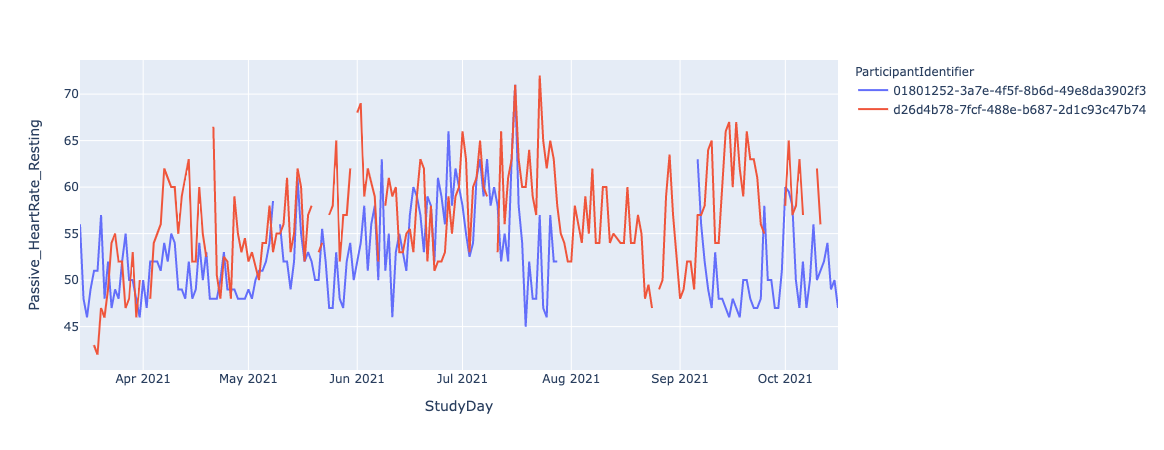

In [154]:
fig = px.line(df, x="StudyDay", y="Passive_HeartRate_Resting", color='ParticipantIdentifier')
fig.show()

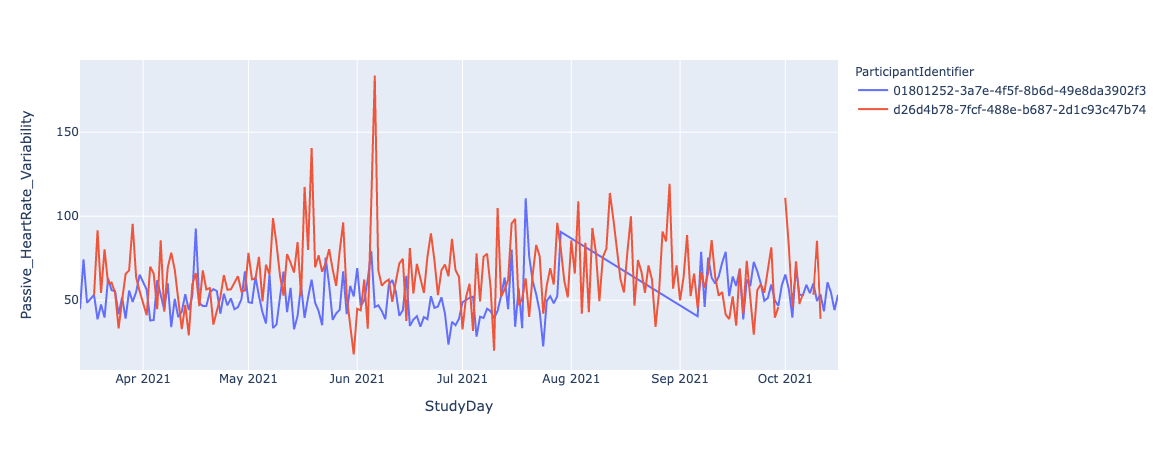

In [155]:
fig = px.line(df, x="StudyDay", y="Passive_HeartRate_Variability", color='ParticipantIdentifier')
fig.show()

### Join

In [156]:
df_passive = df_passive.merge(df, how='left', on=['ParticipantIdentifier', 'StudyDay'])
df_passive.head(3)

,StudyDay,ParticipantIdentifier,Passive_Asleep,Passive_InBed,Passive_HeartRate_Variability,Passive_HeartRate_Resting,Passive_HeartRate_AverageWalking
0,2020-12-11,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,550.083333,NaN,NaN,NaN
1,2020-12-12,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,399.983333,NaN,NaN,NaN
2,2020-12-13,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,423.650000,NaN,NaN,NaN


## Activity

We will take:

- `ActiveEnergyBurned`
- `RestingEnergyBurned`
- `DistanceWalkingRunning`
- `DistanceCycling`
- `AppleStandTime`
- `WalkingSpeed`

Note that for some of these it makes sense to take the daily sum (e.g. `AppleStandTime`) while others make more sense as a daily average (e.g. `WalkingSpeed`)

In [157]:
type_vals_mean = ['WalkingSpeed']

type_vals_sum = ['ActiveEnergyBurned', 'RestingEnergyBurned', 'DistanceWalkingRunning',
                  'DistanceCycling', 'AppleStandTime']

df_mean = app_data['HealthKitSamples'].loc[app_data['HealthKitSamples'].Type.isin(type_vals_mean)].reset_index(drop=True)
df_sum = app_data['HealthKitSamples'].loc[app_data['HealthKitSamples'].Type.isin(type_vals_sum)].reset_index(drop=True)

df_sum.head(3)

,HealthKitSampleKey,ParticipantIdentifier,StartDate,Date,Type,Value,Units,SourceIdentifier,SourceName,SourceVersion,...,DeviceModel,DeviceManufacturer,DeviceHardwareVersion,DeviceSoftwareVersion,DeviceFirmwareVersion,DeviceFDAIdentifier,DeviceLocalIdentifier,Metadata,InsertedDate,StudyDay
0,fffb0d67-092f-ec11-aab2-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-16T22:04:40-07:00,2021-10-16T22:06:28-07:00,DistanceWalkingRunning,61.09000000054948,m,com.apple.health.276E31D9-D0E5-464C-BCF4-36004...,Daniel’s iPhone,14.7.1,...,iPhone,Apple Inc.,"iPhone13,3",14.7.1,NaN,NaN,NaN,{},2021-10-17T05:16:42Z,2021-10-16
1,ae9d5e7c-1a2f-ec11-aab2-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-16T23:59:52-07:00,2021-10-17T00:09:26-07:00,DistanceWalkingRunning,8.3700000001117587,m,com.apple.health.276E31D9-D0E5-464C-BCF4-36004...,Daniel’s iPhone,14.7.1,...,iPhone,Apple Inc.,"iPhone13,3",14.7.1,NaN,NaN,NaN,{},2021-10-17T07:19:02Z,2021-10-16
2,cd570a02-592f-ec11-aab2-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-17T00:10:17-07:00,2021-10-17T00:10:30-07:00,DistanceWalkingRunning,10.950000000419095,m,com.apple.health.276E31D9-D0E5-464C-BCF4-36004...,Daniel’s iPhone,14.7.1,...,iPhone,Apple Inc.,"iPhone13,3",14.7.1,NaN,NaN,NaN,{},2021-10-17T14:46:36Z,2021-10-16


In [158]:
# cast Value to numeric
df_mean.Value = pd.to_numeric(df_mean.Value)
df_sum.Value = pd.to_numeric(df_sum.Value)

# Calculate sums and means
df_mean = pd.DataFrame(df_mean.groupby(['StudyDay','ParticipantIdentifier', 'Type'])['Value'].mean()).reset_index()
df_sum = pd.DataFrame(df_sum.groupby(['StudyDay','ParticipantIdentifier', 'Type'])['Value'].sum()).reset_index()

# convert from long to wide
df_mean = df_mean.pivot_table(index=['StudyDay', 'ParticipantIdentifier'],
                              columns='Type', 
                              values='Value').reset_index()
df_sum = df_sum.pivot_table(index=['StudyDay', 'ParticipantIdentifier'],
                            columns='Type', 
                            values='Value').reset_index()

In [159]:
# Get rid of index name (set to "Type")
df_mean.columns.name = None
df_sum.columns.name = None

# Rename columns
df_mean.rename(columns={'WalkingSpeed': 'Passive_Activity_AverageWalkingSpeed'
                       }, inplace=True)

df_sum.rename(columns={'ActiveEnergyBurned': 'Passive_Activity_ActiveEnergyBurned',
                        'RestingEnergyBurned' : 'Passive_Activity_RestingEnergyBurned',
                        'DistanceWalkingRunning' :'Passive_Activity_DistanceWalkingRunning',
                        'DistanceCycling' : 'Passive_Activity_DistanceCycling',
                        'AppleStandTime': 'Passive_Activity_AppleStandTime'
                       }, inplace=True)

In [160]:
df_sum.head(3)

,StudyDay,ParticipantIdentifier,Passive_Activity_ActiveEnergyBurned,Passive_Activity_AppleStandTime,Passive_Activity_DistanceCycling,Passive_Activity_DistanceWalkingRunning,Passive_Activity_RestingEnergyBurned
0,2020-12-11,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,NaN,NaN,7377.578124,NaN
1,2020-12-12,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,NaN,NaN,6420.280000,NaN
2,2020-12-13,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,NaN,NaN,3026.192706,NaN


### Plot

In [161]:
df_sum.mean()

Passive_Activity_ActiveEnergyBurned         1000.386225
Passive_Activity_AppleStandTime              116.916449
Passive_Activity_DistanceCycling           45801.496118
Passive_Activity_DistanceWalkingRunning     5792.717576
Passive_Activity_RestingEnergyBurned        1642.529770
dtype: float64

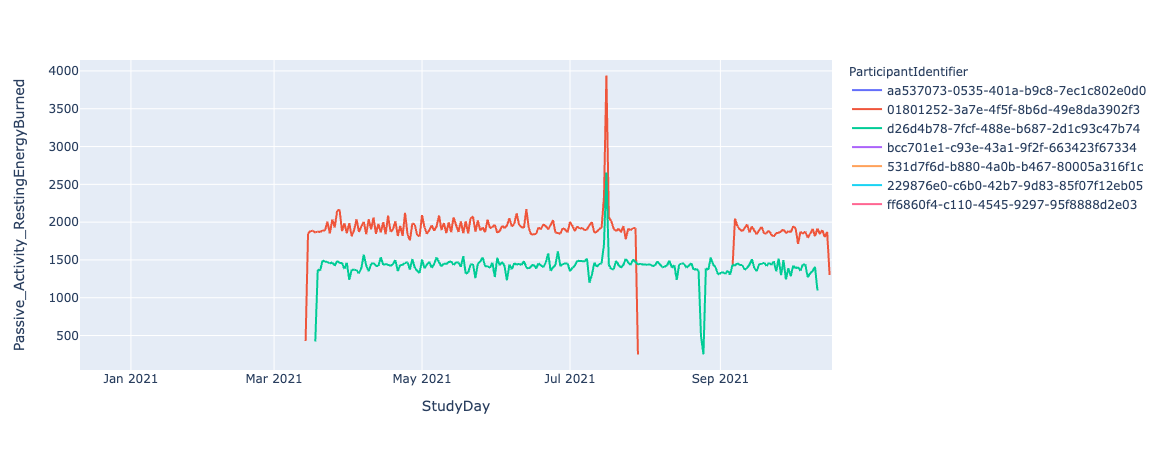

In [162]:
fig = px.line(df_sum, x="StudyDay", y="Passive_Activity_RestingEnergyBurned", color='ParticipantIdentifier')
fig.show()

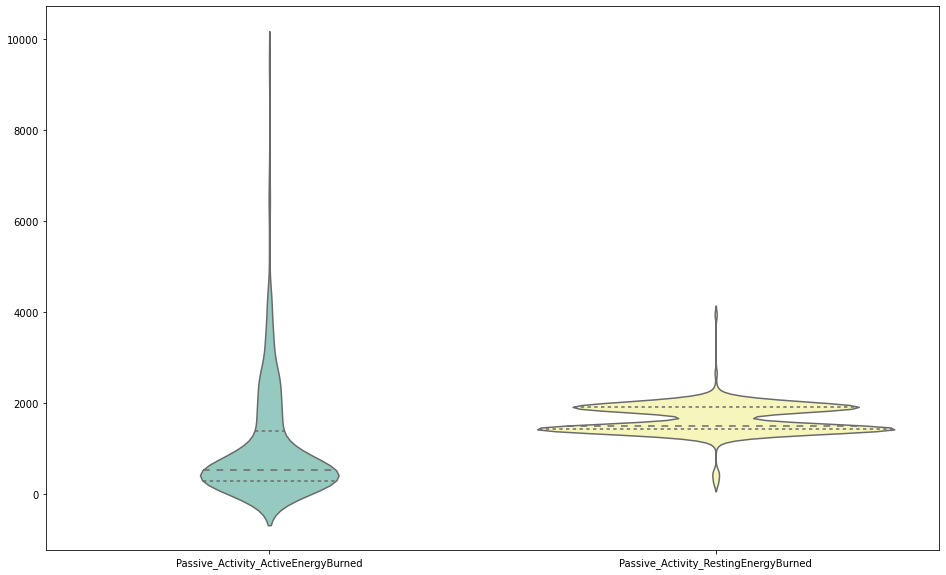

In [163]:
plt.figure(figsize=(16, 10))
sns.violinplot(data=df_sum.loc[:,['Passive_Activity_ActiveEnergyBurned','Passive_Activity_RestingEnergyBurned']],
               inner="quartile", palette="Set3")

### Join

In [164]:
# join
df_passive = df_passive.merge(df_sum, how='left', on=['ParticipantIdentifier', 'StudyDay'])
df_passive = df_passive.merge(df_mean, how='left', on=['ParticipantIdentifier', 'StudyDay'])
df_passive.head(3)

,StudyDay,ParticipantIdentifier,Passive_Asleep,Passive_InBed,Passive_HeartRate_Variability,Passive_HeartRate_Resting,Passive_HeartRate_AverageWalking,Passive_Activity_ActiveEnergyBurned,Passive_Activity_AppleStandTime,Passive_Activity_DistanceCycling,Passive_Activity_DistanceWalkingRunning,Passive_Activity_RestingEnergyBurned,Passive_Activity_AverageWalkingSpeed
0,2020-12-11,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,550.083333,NaN,NaN,NaN,NaN,NaN,NaN,7377.578124,NaN,NaN
1,2020-12-12,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,399.983333,NaN,NaN,NaN,NaN,NaN,NaN,6420.280000,NaN,NaN
2,2020-12-13,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,423.650000,NaN,NaN,NaN,NaN,NaN,NaN,3026.192706,NaN,NaN


## Other

Other data we have captured

- `HeadphoneAudioExposure`
- `EnvironmentalAudioExposure`
- `MindfulSession` (note that this is basically empty)

**NOTE** If using `MindfulSession` then need to set Value to the duration between `StartDate` and `Date`

In [165]:
type_vals = ['HeadphoneAudioExposure', 'EnvironmentalAudioExposure']

df = app_data['HealthKitSamples'].loc[app_data['HealthKitSamples'].Type.isin(type_vals)].reset_index(drop=True)
df.head(3)

,HealthKitSampleKey,ParticipantIdentifier,StartDate,Date,Type,Value,Units,SourceIdentifier,SourceName,SourceVersion,...,DeviceModel,DeviceManufacturer,DeviceHardwareVersion,DeviceSoftwareVersion,DeviceFirmwareVersion,DeviceFDAIdentifier,DeviceLocalIdentifier,Metadata,InsertedDate,StudyDay
0,5afc0d67-092f-ec11-aab2-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-16T22:07:10-07:00,2021-10-16T22:07:11-07:00,HeadphoneAudioExposure,52.454071044921875,dBASPL,com.apple.health.276E31D9-D0E5-464C-BCF4-36004...,Daniel’s iPhone,14.7.1,...,0x200e,Apple Inc.,NaN,NaN,NaN,NaN,74:65:0C:67:E9:5E-tacl,{},2021-10-17T05:16:42Z,2021-10-16
1,8c580a02-592f-ec11-aab2-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-17T00:20:31-07:00,2021-10-17T00:20:34-07:00,HeadphoneAudioExposure,53.492027282714844,dBASPL,com.apple.health.276E31D9-D0E5-464C-BCF4-36004...,Daniel’s iPhone,14.7.1,...,0x200e,Apple Inc.,NaN,NaN,NaN,NaN,74:65:0C:67:E9:5E-tacl,{},2021-10-17T14:46:37Z,2021-10-16
2,93580a02-592f-ec11-aab2-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-17T00:30:46-07:00,2021-10-17T00:35:05-07:00,HeadphoneAudioExposure,30.487780806980801,dBASPL,com.apple.health.276E31D9-D0E5-464C-BCF4-36004...,Daniel’s iPhone,14.7.1,...,0x200e,Apple Inc.,NaN,NaN,NaN,NaN,74:65:0C:67:E9:5E-tacl,{},2021-10-17T14:46:37Z,2021-10-16


In [166]:
# cast Value to float
df.Value = pd.to_numeric(df.Value)

# Get mean for each type for each participant for each day
df = pd.DataFrame(df.groupby(['StudyDay','ParticipantIdentifier', 'Type'])['Value'].mean()).reset_index()

# convert from long to wide
df = df.pivot_table(index=['StudyDay', 'ParticipantIdentifier'],
                    columns='Type', 
                    values='Value').reset_index()

In [167]:
# Get rid of index name (set to "Type")
df.columns.name = None

# Rename columns
df.rename(columns={'HeadphoneAudioExposure': 'Passive_Audio_HeadphoneExposure',
                   'EnvironmentalAudioExposure' : 'Passive_Audio_EnvironmentalExposure'#,
#                   'MindfulSession':'Passive_MindfulSession'
                  }, inplace=True)

df.head(3)

,StudyDay,ParticipantIdentifier,Passive_Audio_EnvironmentalExposure,Passive_Audio_HeadphoneExposure
0,2020-12-11,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,63.822343
1,2020-12-12,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,53.538252
2,2020-12-13,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,65.714693


### Plot

In [168]:
# get dates ordered so plot isn't weird
df.sort_values(by=['StudyDay'], inplace=True)

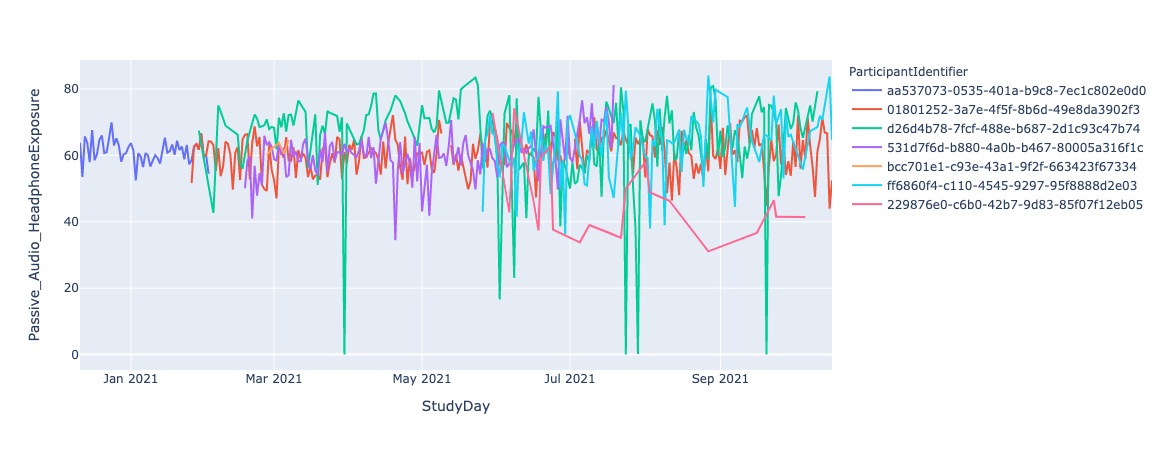

In [169]:
fig = px.line(df, x="StudyDay", y="Passive_Audio_HeadphoneExposure", color='ParticipantIdentifier')
fig.show()

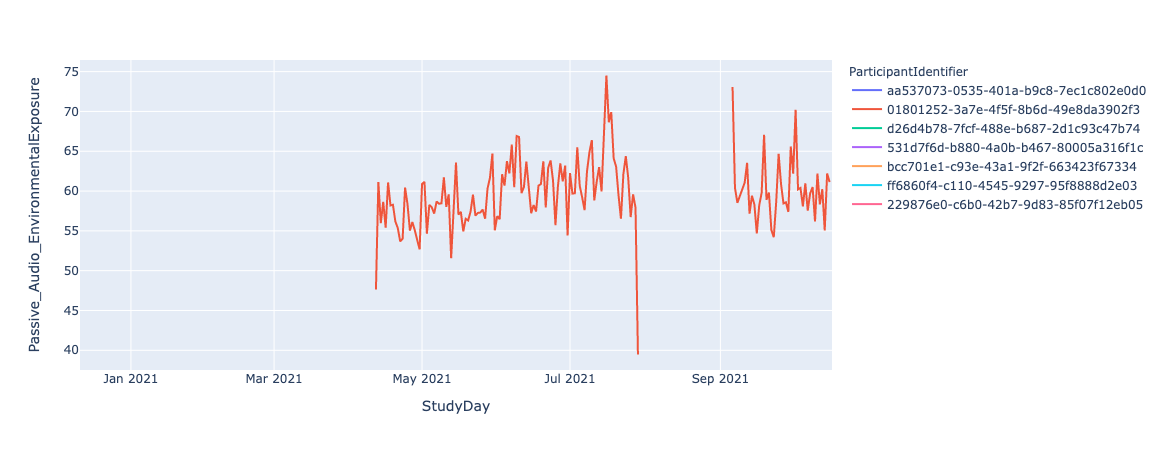

In [170]:
fig = px.line(df, x="StudyDay", y="Passive_Audio_EnvironmentalExposure", color='ParticipantIdentifier')
fig.show()

### Join

In [171]:
# join
df_passive = df_passive.merge(df, how='left', on=['ParticipantIdentifier', 'StudyDay'])
df_passive.head(3)

,StudyDay,ParticipantIdentifier,Passive_Asleep,Passive_InBed,Passive_HeartRate_Variability,Passive_HeartRate_Resting,Passive_HeartRate_AverageWalking,Passive_Activity_ActiveEnergyBurned,Passive_Activity_AppleStandTime,Passive_Activity_DistanceCycling,Passive_Activity_DistanceWalkingRunning,Passive_Activity_RestingEnergyBurned,Passive_Activity_AverageWalkingSpeed,Passive_Audio_EnvironmentalExposure,Passive_Audio_HeadphoneExposure
0,2020-12-11,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,550.083333,NaN,NaN,NaN,NaN,NaN,NaN,7377.578124,NaN,NaN,NaN,63.822343
1,2020-12-12,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,399.983333,NaN,NaN,NaN,NaN,NaN,NaN,6420.280000,NaN,NaN,NaN,53.538252
2,2020-12-13,aa537073-0535-401a-b9c8-7ec1c802e0d0,NaN,423.650000,NaN,NaN,NaN,NaN,NaN,NaN,3026.192706,NaN,NaN,NaN,65.714693


## Locations

**NOT CURRENTLY USING THIS DATA**

In [23]:
locations = app_data['AppleLocationVisits']
# limit to one participant
locations = locations.loc[locations.ParticipantIdentifier=='01801252-3a7e-4f5f-8b6d-49e8da3902f3']
locations.head(2)

,AppleLocationVisitKey,ParticipantIdentifier,ArrivalTime,DepartureTime,Latitude,Longitude,HorizontalAccuracy,InsertedDate
0,01141402-8885-eb11-aaa6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-03-15T08:09:16-04:00,NaN,45.525129,-73.580157,65.000000,2021-03-15T12:14:44Z
1,efb54780-8985-eb11-aaa6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-03-15T08:09:16-04:00,2021-03-15T08:20:02-04:00,45.523456,-73.579740,114.071951,2021-03-15T12:25:24Z


In [24]:
locations.ParticipantIdentifier.value_counts()

01801252-3a7e-4f5f-8b6d-49e8da3902f3    234
Name: ParticipantIdentifier, dtype: int64

In [25]:
# Montreal shape files https://donnees.montreal.ca/search?q=res_format:SHP&from=10

neighborhood_map = gpd.read_file('data/geobase/geobase_mtl.shp')

In [26]:
# convert coordinate reference system
neighborhood_map = neighborhood_map.to_crs("EPSG:4326")

In [27]:
# convert location points to geometry
geometry = [Point(xy) for xy in zip(locations.Longitude, locations.Latitude)]

In [28]:
# specify coordinate reference system
crs = {'init': "EPSG:4326"}

In [29]:
geo_df = gpd.GeoDataFrame(locations,
                         crs = crs,
                         geometry = geometry)

/Users/djw/opt/miniconda3/envs/thesis_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



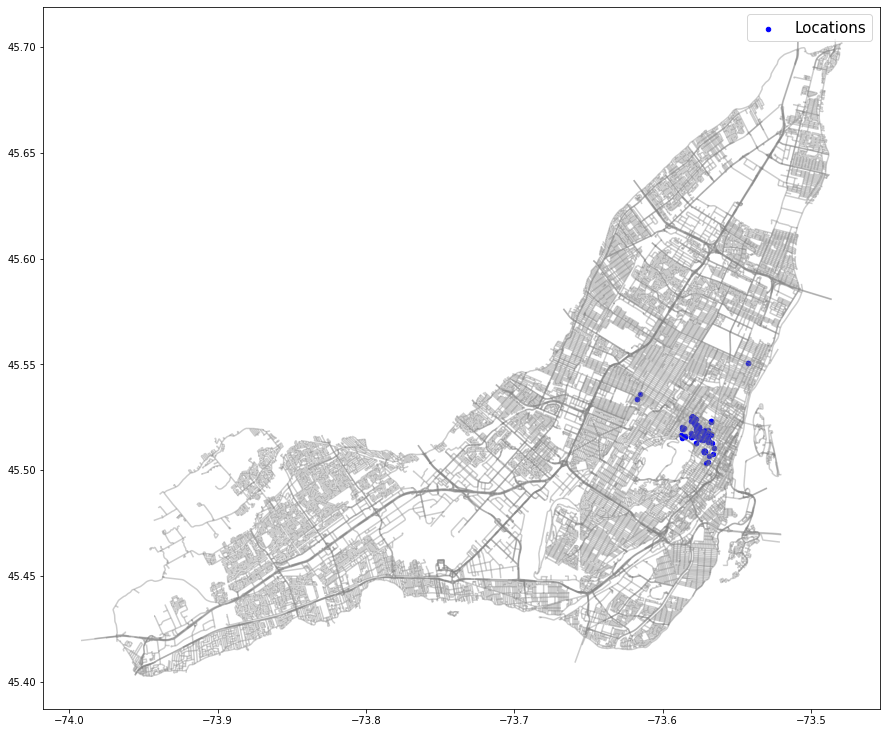

In [30]:
fig,ax = plt.subplots(figsize = (15,15))
neighborhood_map.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df.plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = "Locations")
plt.legend(prop={'size': 15})

# Export DF

In [172]:
df_passive.to_csv('data/features/passive_features.csv')

# Plot

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
sns.set_theme(style="white")

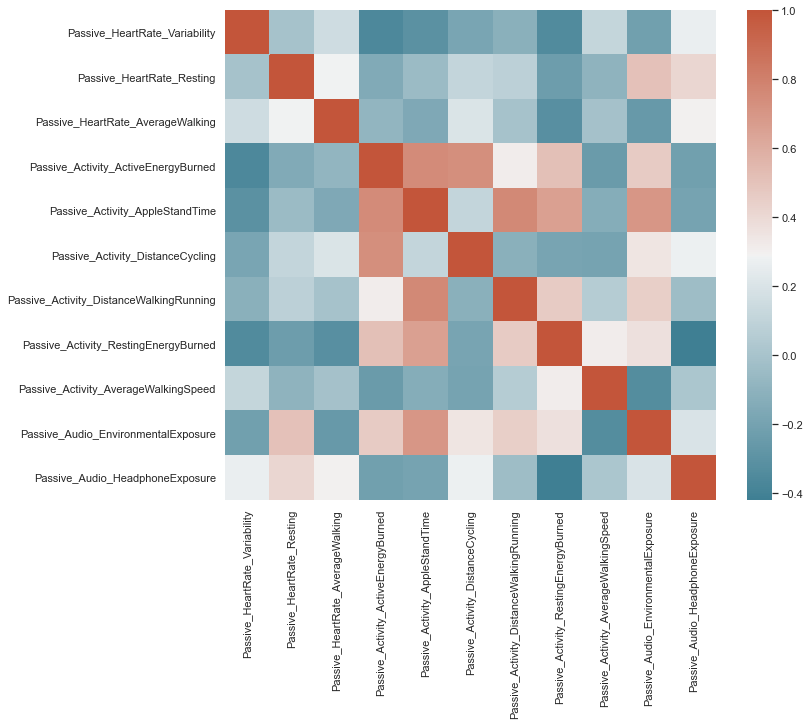

In [120]:
# Compute the correlation matrix
corr = df_passive.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, n=9, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap)